# Set up original restraints (from `02-confirm-restraints`) and add information for `.phase['release']` instead of setting up dedicated release-only restraints and then fussing with `collect_data()` in `analysis.py`

In [3]:
hg = pmd.load_file(
    "systems/a-bam-p/smirnoff/a000/smirnoff.prmtop",
    "systems/a-bam-p/smirnoff/a000/smirnoff.inpcrd",
    structure=True,
)

dummy_anchors = [":8", ":9", ":10"]
host_anchors = [":1@O3", ":3@C1", ":5@C6"]
guest_anchors = [":7@C4", ":7@N1"]


In [4]:
attach_string = (
    "0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 18.10 24.40 37.00 49.60 74.80 100.00"
)
attach_fractions = [float(i) / 100 for i in attach_string.split()]

pull_string = "0.00 0.40 0.80 1.20 1.60 2.00 2.40 2.80 3.20 3.60 4.00 4.40 4.80 5.20 5.60 6.00 6.40 6.80 7.20 7.60 8.00 8.40 8.80 9.20 9.60 10.00 10.40 10.80 11.20 11.60 12.00 12.40 12.80 13.20 13.60 14.00 14.40 14.80 15.20 15.60 16.00 16.40 16.80 17.20 17.60 18.00"
pull_distances = [float(i) + 6.00 for i in pull_string.split()]

release_fractions = attach_fractions[::-1]

windows = [len(attach_fractions), len(pull_distances), len(release_fractions)]
print(f"There are {windows} windows in this attach-pull-release calculation.")


## Restraint definitions

### Static restraints connecting the host and dummy atoms

In [6]:
static_restraint_atoms = [[dummy_anchors[0], host_anchors[0]],
                          [dummy_anchors[1], dummy_anchors[0], host_anchors[0]],
                          [dummy_anchors[2], dummy_anchors[1], dummy_anchors[0], host_anchors[0]],
                          [dummy_anchors[0], host_anchors[0], host_anchors[1]],
                          [dummy_anchors[1], dummy_anchors[0], host_anchors[0], host_anchors[1]],
                          [dummy_anchors[0], host_anchors[0], host_anchors[1], host_anchors[2]],
                        ]

static_restraint_distance_fc = 5.0
static_restraint_angle_fc = 100.0

### Guest restraints connecting the guest and dummy atoms

In [7]:
guest_restraint_atoms = [[dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[1], dummy_anchors[0], guest_anchors[0]],
                         [dummy_anchors[0], guest_anchors[0], guest_anchors[1]],
                        ]

guest_restraint_targets = [6.0,
                           180.0,
                           180.0
                          ]
guest_restraint_target_final = [24.0, 180.0, 180.0]
guest_restraint_distance_fc = 5.0
guest_restraint_angle_fc = 100.0

### Host conformational restraints

In [8]:
host_conformational_template = [['O5', 'C1', 'O1', 'C4'],
                                ['C1', 'O1', 'C4', 'C5']
                               ]

host_residues = len(hg[':MGO'].residues)
first_host_residue = hg[':MGO'].residues[0].number + 1
conformational_restraint_atoms = []
conformational_restraint_targets = []
conformational_restraint_fc = 6.0

for n in range(first_host_residue, host_residues + first_host_residue):
    if n + 1 < host_residues + first_host_residue:
        next_residue = n + 1
    else:
        next_residue = first_host_residue
    conformational_restraint_atoms.append(
        [f':{n}@{host_conformational_template[0][0]}',
         f':{n}@{host_conformational_template[0][1]}',
         f':{n}@{host_conformational_template[0][2]}',
         f':{next_residue}@{host_conformational_template[0][3]}'
        ])
    conformational_restraint_targets.append(104.30)
    conformational_restraint_atoms.append(
        [f':{n}@{host_conformational_template[1][0]}',
         f':{n}@{host_conformational_template[1][1]}',
         f':{next_residue}@{host_conformational_template[1][2]}',
         f':{next_residue}@{host_conformational_template[1][3]}'
        ])
    conformational_restraint_targets.append(-108.8)

### Guest wall restraints

In [9]:
guest_wall_template = [
    ['O2', guest_anchors[0]],
    ['O6', guest_anchors[0]]
]

guest_wall_restraint_atoms = []
guest_wall_restraint_targets = []
guest_wall_restraint_angle_fc = 500.0
guest_wall_restraint_distance_fc = 50.0

for n in range(first_host_residue, host_residues + first_host_residue):
    guest_wall_restraint_atoms.append(
        [f':{n}@{guest_wall_template[0][0]}',
         f'{guest_wall_template[0][1]}',
        ])
    guest_wall_restraint_targets.append(11.3)
    guest_wall_restraint_atoms.append(
        [f':{n}@{guest_wall_template[1][0]}',
         f'{guest_wall_template[1][1]}',
        ])
    guest_wall_restraint_targets.append(13.3)

guest_wall_restraint_atoms.append([dummy_anchors[1],
                                 guest_anchors[0],
                                 guest_anchors[1]])
guest_wall_restraint_targets.append(80.0)

## Initialize the restraints

### Static restraints

In [10]:
static_restraints = []
for index, atoms in enumerate(static_restraint_atoms):    
    this = static_DAT_restraint(restraint_mask_list=atoms,
                        num_window_list=windows, 
                        ref_structure=hg,
                        force_constant=static_restraint_angle_fc if len(atoms) > 2 else static_restraint_distance_fc,
                        amber_index=True)
    static_restraints.append(this)

2018-06-04 11:09:35 AM Calculating attach targets and force constants...
2018-06-04 11:09:35 AM Attach, Method #1
2018-06-04 11:09:35 AM Calculating pull targets and force constants...
2018-06-04 11:09:35 AM Pull, Method #1
2018-06-04 11:09:35 AM Calculating release targets and force constants...
2018-06-04 11:09:35 AM Release, Method #1
2018-06-04 11:09:35 AM Number of attach windows = 15
2018-06-04 11:09:35 AM Number of pull windows = 46
2018-06-04 11:09:35 AM Number of release windows = 15
2018-06-04 11:09:35 AM Assigning atom indices...
2018-06-04 11:09:35 AM There are 1 atoms in the mask :8  ...
2018-06-04 11:09:35 AM There are 1 atoms in the mask :1@O3  ...
2018-06-04 11:09:36 AM Calculating attach targets and force constants...
2018-06-04 11:09:36 AM Attach, Method #1
2018-06-04 11:09:36 AM Calculating pull targets and force constants...
2018-06-04 11:09:36 AM Pull, Method #1
2018-06-04 11:09:36 AM Calculating release targets and force constants...
2018-06-04 11:09:36 AM Release

### Guest restraints

In [11]:
guest_restraints = []
for index, atoms in enumerate(guest_restraint_atoms): 
    if len(atoms) > 2:
        angle = True
    else:
        angle = False
    this = DAT_restraint()
    this.auto_apr = True
    this.amber_index = True
    this.topology = hg
    this.mask1 = atoms[0]
    this.mask2 = atoms[1]
    if angle:
        this.mask3 = atoms[2]
        this.attach['fc_final'] = guest_restraint_angle_fc
        this.release['fc_final'] = guest_restraint_angle_fc
    else:
        this.attach['fc_final'] = guest_restraint_distance_fc
        this.release['fc_final'] = guest_restraint_distance_fc
    this.attach['target'] = guest_restraint_targets[index]
    this.attach['fraction_list'] = attach_fractions
    
    this.pull['target_final'] = guest_restraint_target_final[index]
    this.pull['num_windows'] = windows[1]
    
    this.release['target'] = guest_restraint_targets[index]
    # Keep the guest restraints on during release.
    this.release['fraction_list'] = [1.0] * windows[2]
    
    this.initialize()
    guest_restraints.append(this)

2018-06-04 11:09:38 AM Calculating attach targets and force constants...
2018-06-04 11:09:38 AM Attach, Method #3
2018-06-04 11:09:38 AM Calculating pull targets and force constants...
2018-06-04 11:09:38 AM Pull, Method #1
2018-06-04 11:09:38 AM Calculating release targets and force constants...
2018-06-04 11:09:38 AM Release, Method #3
2018-06-04 11:09:38 AM Number of attach windows = 15
2018-06-04 11:09:38 AM Number of pull windows = 46
2018-06-04 11:09:38 AM Number of release windows = 15
2018-06-04 11:09:38 AM Assigning atom indices...
2018-06-04 11:09:38 AM There are 1 atoms in the mask :8  ...
2018-06-04 11:09:38 AM There are 1 atoms in the mask :7@C4  ...
2018-06-04 11:09:38 AM Calculating attach targets and force constants...
2018-06-04 11:09:38 AM Attach, Method #3
2018-06-04 11:09:38 AM Calculating pull targets and force constants...
2018-06-04 11:09:38 AM Pull, Method #1
2018-06-04 11:09:38 AM Calculating release targets and force constants...
2018-06-04 11:09:38 AM Release

### Host conformational restraints

In [5]:
conformational_restraints = []
for index, atoms in enumerate(conformational_restraint_atoms):

    this = DAT_restraint()
    this.auto_apr = True
    this.amber_index = True
    this.topology = hg
    this.mask1 = atoms[0]
    this.mask2 = atoms[1]
    this.mask3 = atoms[2]
    this.mask4 = atoms[3]

    this.attach["fraction_list"] = attach_fractions
    this.attach["target"] = conformational_restraint_targets[index]
    this.attach["fc_final"] = conformational_restraint_fc
    this.pull["target_final"] = conformational_restraint_targets[index]
    this.pull["num_windows"] = windows[1]

    this.release["fraction_list"] = release_fractions
    this.release["target"] = conformational_restraint_targets[index]
    this.release["fc_final"] = conformational_restraint_fc

    this.initialize()
    conformational_restraints.append(this)


### Guest wall restraints

In [13]:
wall_restraints = []
for index, atoms in enumerate(guest_wall_restraint_atoms): 
    if len(atoms) > 2:
        angle = True
    else:
        angle = False
    
    this = DAT_restraint()
    this.auto_apr = True
    this.amber_index = True
    this.topology = hg
    this.mask1 = atoms[0]
    this.mask2 = atoms[1]
    if angle:
        this.mask3 = atoms[2]
        this.attach['fc_initial'] = guest_wall_restraint_angle_fc
        this.attach['fc_final'] = guest_wall_restraint_angle_fc
        this.custom_restraint_values['rk2'] = 500.0
        this.custom_restraint_values['rk3'] = 0.0
    else:
        this.attach['fc_initial'] = guest_wall_restraint_distance_fc
        this.attach['fc_final'] = guest_wall_restraint_distance_fc
        this.custom_restraint_values['rk2'] = 50.0
        this.custom_restraint_values['rk3'] = 50.0
        this.custom_restraint_values['r1'] = 0.0
        this.custom_restraint_values['r2'] = 0.0

    this.attach['target'] = guest_wall_restraint_targets[index]
    this.attach['num_windows'] = len(attach_fractions)
       
    this.initialize()
    wall_restraints.append(this)

2018-06-04 11:09:40 AM Calculating attach targets and force constants...
2018-06-04 11:09:40 AM Attach, Method #1
2018-06-04 11:09:40 AM Calculating pull targets and force constants...
2018-06-04 11:09:40 AM No restraint info set for the pull phase! Skipping...
2018-06-04 11:09:40 AM Calculating release targets and force constants...
2018-06-04 11:09:40 AM No restraint info set for the release phase! Skipping...
2018-06-04 11:09:40 AM Number of attach windows = 15
2018-06-04 11:09:40 AM This restraint will be skipped in the pull phase
2018-06-04 11:09:40 AM This restraint will be skipped in the release phase
2018-06-04 11:09:40 AM Assigning atom indices...
2018-06-04 11:09:40 AM There are 1 atoms in the mask :1@O2  ...
2018-06-04 11:09:40 AM There are 1 atoms in the mask :7@C4  ...
2018-06-04 11:09:40 AM Calculating attach targets and force constants...
2018-06-04 11:09:40 AM Attach, Method #1
2018-06-04 11:09:40 AM Calculating pull targets and force constants...
2018-06-04 11:09:40 AM

In [14]:
window_list = create_window_list(guest_restraints)

2018-06-04 11:09:41 AM All restraints are "continuous_apr" style.
2018-06-04 11:09:41 AM Restraints appear to be consistent


In [15]:
# for window in window_list:
#     if not os.path.isdir(os.path.join(prefix, 'smirnoff', window)):
#         print(f'Creating {os.path.join(prefix, "smirnoff", window)}')
#         os.makedirs(os.path.join(prefix, 'smirnoff', window))


In [16]:
# files = ['smirnoff.prmtop',
#         'smirnoff.inpcrd',
#         ]

# for window_index, window in enumerate([i for i in window_list if i[0] == 'r']):
#     for file in files:
#         if os.path.isfile(os.path.join(prefix, 'smirnoff', window, file)):
#             os.remove(os.path.join(prefix, 'smirnoff', window, file))
#         try:
#             os.symlink(os.path.join('../', 'p045', file),
#                        os.path.join(prefix, 'smirnoff', window, file))        
#         except:
#             pass

In [17]:
# print('Writing restratint file in each window...')
# for window in window_list:
#     with open(os.path.join(prefix, 'smirnoff', window, 'disang.rest'), 'w') as file:
#         for restraint in static_restraints + guest_restraints + \
#                           conformational_restraints + wall_restraints:
#             if window[0] == 'a':
#                 phase = 'attach'
#             if window[0] == 'p':
#                 phase = 'pull'
#             if window[0] == 'r':
#                 phase = 'release'

#             try:
#                 string = amber_restraint_line(restraint, phase, int(window[1:]))
#             except:
#                 # Hack to get around trying to access
#                 # --> 630         'r2': restraint.phase[phase]['targets'][window],
#                 # for wall restraints, during pull.
#                 continue
#             if string is not None:
#                 file.write(string)

In [18]:
structure = pt.load(
    os.path.join('systems', 'a-bam-p', 'smirnoff', 'a000', 'smirnoff.inpcrd'),
    os.path.join('systems', 'a-bam-p', 'smirnoff', 'a000', 'smirnoff.prmtop'))

stripped = structure.strip(':WAT,:Na+,:Cl-')

In [36]:
analyze = fe_calc()
analyze.prmtop = stripped.topology
analyze.trajectory = 'prod.*.nc'
analyze.path = os.path.join('/home', 'dslochower', 'kirkwood', 'projects', 'smirnoff-host-guest-simulations', 
                            'systems', 'a-bam-p', 'smirnoff')


In [37]:
analyze.restraint_list = guest_restraints + conformational_restraints
analyze.collect_data()
analyze.methods = ['ti-block']
analyze.quicker_ti_matrix = True
analyze.bootcycles = 1000
analyze.compute_free_energy()

2018-06-05 09:13:58 AM Replacing /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a014 with /home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/p000 in ['/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a000', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a001', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a002', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a003', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a004', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a005', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulations/systems/a-bam-p/smirnoff/a006', '/home/dslochower/kirkwood/projects/smirnoff-host-guest-simulati

In [38]:
analyze.compute_ref_state_work([guest_restraints[0], guest_restraints[1], None, None, guest_restraints[2], None])

In [39]:
print(f"{'Attach': <10} {analyze.results['attach']['ti-block']['fe']:+04.2f} +/- {analyze.results['attach']['ti-block']['sem']:2.2f}")
print(f"{'Pull': <10} {analyze.results['pull']['ti-block']['fe']:+04.2f} +/- {analyze.results['pull']['ti-block']['sem']:2.2f}")
print(f"{'Release': <10} {analyze.results['release']['ti-block']['fe']:+04.2f} +/- {analyze.results['release']['ti-block']['sem']:2.2f}")
print(f"{'Reference': <10} {analyze.results['ref_state_work']:+04.2f}")

fe = analyze.results['attach']['ti-block']['fe'] + analyze.results['pull']['ti-block']['fe'] + analyze.results['release']['ti-block']['fe'] + analyze.results['ref_state_work']
sem = np.sqrt( (analyze.results['attach']['ti-block']['sem']**2 + \
                analyze.results['pull']['ti-block']['sem']**2 + \
                analyze.results['release']['ti-block']['sem']**2
               )
             )
print(f"{'Total': <10} {fe:+2.2f} +/- {sem:2.2f}")

Attach     +13.06 +/- 0.13
Pull       +4.17 +/- 0.32
Release    -7.87 +/- 0.15
Reference  -7.14
Total      +2.23 +/- 0.38


In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
attach_fe = analyze.results['attach']['ti-block']['fe_matrix'][0]
attach_sem = analyze.results['attach']['ti-block']['sem_matrix'][0]

pull_fe = analyze.results['pull']['ti-block']['fe_matrix'][0]
pull_sem =  analyze.results['pull']['ti-block']['sem_matrix'][0]

release_fe = analyze.results['release']['ti-block']['fe_matrix'][0]
release_sem = analyze.results['release']['ti-block']['sem_matrix'][0]

reference = analyze.results['ref_state_work']

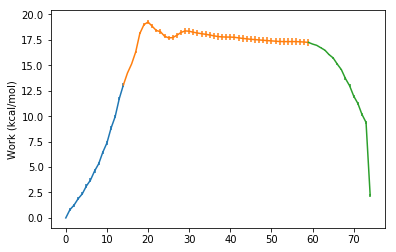

In [25]:
plt.errorbar(range(0, 15), attach_fe, attach_sem)
plt.errorbar(range(14, 60), attach_fe[-1] + pull_fe, pull_sem)
plt.errorbar(range(59, 75), list(attach_fe[-1] + pull_fe[-1] + -1 * release_fe) + \
             [attach_fe[-1] + pull_fe[-1] + -1 * release_fe[-1] + reference], list(release_sem) + [release_sem[-1]])
plt.ylabel('Work (kcal/mol)')
# plt.xticks([0, 14], [0, 1])

In [26]:
[attach_fe[-1] + pull_fe[-1] + -1 * release_fe]

[array([ 17.25359325,  17.08894145,  16.96612657, ...,  11.26187522,
         10.1830019 ,   9.38938173])]

In [27]:
attach_fe[-1] + pull_fe[-1] + -1 * release_fe[-1] + reference

2.2478671461209281

In [28]:
list(attach_fe[-1] + pull_fe[-1] + -1 * release_fe) + [attach_fe[-1] + pull_fe[-1] + -1 * release_fe[-1] + reference]

[17.253593253215545,
 17.088941451935447,
 16.96612657388884,
 16.726684691102371,
 16.489381972441709,
 16.056267328002438,
 15.728459035772984,
 15.12120653862547,
 14.577664329780678,
 13.69476943209415,
 12.993971753136099,
 11.975740661050498,
 11.261875219554479,
 10.183001904191405,
 9.3893817289829329,
 2.2478671461209281]

In [29]:
attach_fe[-1] + pull_fe[-1] + -1 * release_fe[-1] + reference

2.2478671461209281

In [30]:
analyze.results

{'attach': {'ti-block': {'fe': 13.069227450518049,
   'sem': 0.17033078770001153,
   'fe_matrix': array([[  0.        ,   0.80498234,   1.25381414, ...,   9.94782099,
            11.72279341,  13.06922745],
          [ -0.80498234,   0.        ,   0.        , ...,   0.        ,
             0.        ,  12.25876651],
          [ -1.25381414,  -0.        ,   0.        , ...,   0.        ,
             0.        ,  11.81164671],
          ..., 
          [ -9.94782099,  -0.        ,  -0.        , ...,   0.        ,
             0.        ,   3.11112201],
          [-11.72279341,  -0.        ,  -0.        , ...,  -0.        ,
             0.        ,   1.33108522],
          [-13.06922745, -12.25876651, -11.81164671, ...,  -3.11112201,
            -1.33108522,   0.        ]]),
   'sem_matrix': array([[ 0.        ,  0.13566964,  0.14063094, ...,  0.16820173,
            0.16884535,  0.17033079],
          [ 0.13566964,  0.        ,  0.        , ...,  0.        ,
            0.        ,  0.

In [31]:
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [32]:
json.dumps(analyze.results, cls=MyEncoder)

'{"attach": {"ti-block": {"fe": 13.06922745051805, "sem": 0.17033078770001153, "fe_matrix": [[0.0, 0.8049823369768476, 1.2538141432867704, 1.8843841780029662, 2.3585641519369056, 3.129265958047895, 3.717417939138927, 4.612060514796149, 5.323429061854526, 6.45790056631627, 7.36818827426182, 8.821411078614016, 9.94782098569577, 11.722793414288285, 13.06922745051805], [-0.8049823369768476, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.258766514220065], [-1.2538141432867704, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.811646706258347], [-1.8843841780029662, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.179493187840565], [-2.3585641519369056, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.706422421877766], [-3.129265958047895, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.93286289573411], [-3.717417939138927, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [33]:
with open('tmp.json', 'w') as file:
    json.dump(analyze.results, cls=MyEncoder, fp=file)

In [34]:
from paprika.analysis import save

In [40]:
save(analyze, 'smirnoff-results.json')